In [1]:
# define GPU
import os
import logging
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../'))

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


In [2]:
!nvidia-smi


Thu Aug  3 12:44:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:41:00.0 Off |                  N/A |
| 30%   37C    P8    25W / 320W |     61MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:61:00.0 Off |                  N/A |
| 37%   

In [3]:
from tqdm import tqdm
import copy
import pickle
import numpy as np
import torch
import torchvision
import utils
import nids_models
import nids_federated_learning as fl
import nids_training 
from torch import nn
from nids_models import DNN
from utils import CustomDataset, CustomDataset1
from nids_training import evaluate_model
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
import importlib
importlib.reload(utils)
importlib.reload(nids_models)
importlib.reload(fl)


<module 'nids_federated_learning' from '/home/mark/Mark/FL_NIDS/federated_nids/nids_federated_learning.py'>

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Define dataset and settings.
dataset_name = 'nids'

# Define distribution settings.
num_clients = 4
# beta = 0.1 # [0.1, 0.5, 5]

client_data_dir = os.path.join('./client_data/', dataset_name)
save_dir = os.path.join('./output_nids/dnn_fedavg', dataset_name)
os.makedirs(save_dir, exist_ok=True)
os.makedirs(client_data_dir, exist_ok=True)

In [6]:
### Data config.
batch_size = 32

# Training config.
lr = 0.0002
num_rounds = 5 #2000 rounds
num_local_epochs = 5
save_interval = 1

In [7]:
# This testing data includes all attack types from clients, created from centralized one.
data_dir = os.path.join('./datasets/', dataset_name)
test_dir = os.path.join(data_dir, 'test/')

# # Open the pickle file in read mode
# with open(test_dir + 'test.pkl', 'rb') as file:
#     # Load the co"ntents of the pickle file
#     test_data = pickle.load(file)
    
# test_data = np.load(test_dir + 'test.npy', allow_pickle=True)
# test_data = torch.load(test_dir + 'test.pkl')
test_data = torch.load(test_dir + 'test_central_new.pkl')
print(type(test_data))

<class 'utils.CustomDataset'>


In [8]:
len(test_data)

129238

In [9]:
test_data

In [10]:
test_loader = test_data

In [11]:
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)

In [12]:
# Load client data.
client_loaders = []
for client_idx in range(num_clients):
    data_dir = os.path.join(client_data_dir, str(client_idx) + '/{}_train_new.csv'.format(str(client_idx)))
    # data_dir = os.path.join(client_data_dir, str(client_idx) + '/{}_sub.csv'.format(str(client_idx)))
    # os.makedirs(data_dir, exist_ok=True)
    print(data_dir)
    dataset = CustomDataset(data_dir)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    client_loaders.append(data_loader)

./client_data/nids/0/0_train_new.csv
./client_data/nids/1/1_train_new.csv
./client_data/nids/2/2_train_new.csv
./client_data/nids/3/3_train_new.csv


In [13]:
# Global model.
input_size = 1525  # Number of features in the dataset
# hidden_size = 256
num_classes = 2

glob_model = DNN(input_size, [512, 256, 128, 64], num_classes).to(device)

# For logging model performance.
performance_dict, performance_log = dict(), dict()
metric_keys = ['g_train_loss', 'g_test_loss']
for metric in metric_keys:
    performance_dict[metric] = utils.MeanMetric()
    performance_log[metric] = list()

performance_dict, performance_log = utils.get_performance_loggers(metric_keys)

In [14]:
save_dir

'./output_nids/dnn_fedavg/nids'

In [15]:
# Automatic resuming from checkpoint.
log_path = os.path.join(save_dir, 'performance_log.pickle')
if os.path.isfile(log_path):
    performance_log = utils.load_pickle(log_path)
start_round = len(performance_log[metric_keys[0]])

if start_round > 0:
    glob_model.load_state_dict(torch.load(os.path.join(save_dir, 'g_r_{}.pth'.format(start_round))))

In [16]:
lambda_ = 0.1

In [17]:
glob_w = glob_model.state_dict()

optim_args = {'lr': lr}
loss_function = nn.CrossEntropyLoss()

for round_no in range(start_round, num_rounds):
    utils.print_separator(text='Round: {} / {}'.format(round_no + 1, num_rounds))
                
    # Local training.
    glob_model.train()
    client_updates = dict()
    for client_idx in range(num_clients):  
        print('client:', client_idx)
        client_loader = client_loaders[client_idx] # update new samples
        
        # Local training.
        client_update = fl.local_update_fedavg(glob_model, client_loader, test_loader, num_local_epochs, optim_args)
        
        # For weighted averaging.
        client_updates.setdefault('local_w', list()).append(client_update['local_w'])
        client_updates.setdefault('num_samples', list()).append(client_update['num_samples'])
        
        # Logging client performance.
        performance_log.setdefault('c_{}_train_loss'.format(client_idx), list()).append(client_update['train_loss'])
        performance_log.setdefault('c_{}_test_loss'.format(client_idx), list()).append(client_update['test_loss'])
            
    # Model aggregation.
    glob_w = fl.weighted_averaging(client_updates['local_w'], client_updates['num_samples'])
    glob_model.load_state_dict(glob_w)
    
    # Evaluate global model on local datasets.
    for client_idx in range(num_clients):
        g_train_loss = evaluate_model(glob_model, client_loader, loss_function, tqdm_desc='g_train_loss')
        performance_dict['g_train_loss'].update_state(g_train_loss)
        
    # Average local performace of global model.
    performance_log['g_train_loss'].append(performance_dict['g_train_loss'].result())
    performance_dict['g_train_loss'].reset_state()
    
    # Evaluate global model on global testset.
    g_test_loss = evaluate_model(glob_model, test_loader, loss_function, tqdm_desc='g_test_loss')
    performance_log['g_test_loss'].append(g_test_loss)
    
#     for key in sorted(performance_log.keys()):
#         print(key, ': ',  performance_log[key][-1])
    
    for key in sorted(metric_keys):
        print(key, ': ',  performance_log[key][-1])
    
    # Save global model.
    if (round_no + 1) % save_interval == 0:
        torch.save(glob_model.state_dict(), os.path.join(save_dir, 'g_r_{}.pth'.format(round_no + 1)))
        utils.save_pickle(log_path, performance_log)

    # Save client models only in the last round. To save space.
    if round_no + 1 == num_rounds:
        for client_idx in range(num_clients):
            local_state_dict = client_updates['local_w'][client_idx]
            torch.save(local_state_dict, os.path.join(save_dir, 'c_{}_r_{}.pth'.format(client_idx, round_no + 1)))


 ==================== Round: 1 / 5 ====================

client: 0


local_test_loss: 100%|████████████████| 129238/129238 [00:28<00:00, 4486.23it/s]


client: 1


local_test_loss: 100%|████████████████| 129238/129238 [00:27<00:00, 4734.85it/s]


client: 2


local_test_loss: 100%|████████████████| 129238/129238 [00:27<00:00, 4774.23it/s]


client: 3


g_test_loss: 100%|████████████████████| 129238/129238 [00:26<00:00, 4788.23it/s]


g_test_loss :  0.1694595222996362
g_train_loss :  0.08644386395416992

 ==================== Round: 2 / 5 ====================

client: 0


local_test_loss: 100%|████████████████| 129238/129238 [00:27<00:00, 4762.74it/s]


client: 1


local_test_loss: 100%|████████████████| 129238/129238 [00:26<00:00, 4796.14it/s]


client: 2


local_test_loss: 100%|████████████████| 129238/129238 [00:27<00:00, 4770.59it/s]


client: 3


g_test_loss: 100%|████████████████████| 129238/129238 [00:28<00:00, 4517.52it/s]


g_test_loss :  0.3370930691132048
g_train_loss :  0.11474353088770314

 ==================== Round: 3 / 5 ====================

client: 0


local_test_loss: 100%|████████████████| 129238/129238 [00:26<00:00, 4800.11it/s]


client: 1


local_test_loss: 100%|████████████████| 129238/129238 [00:26<00:00, 4790.81it/s]


client: 2


local_test_loss: 100%|████████████████| 129238/129238 [00:26<00:00, 4828.84it/s]


client: 3


g_test_loss: 100%|████████████████████| 129238/129238 [00:27<00:00, 4744.85it/s]


g_test_loss :  0.3110015713287909
g_train_loss :  0.06944512687084897

 ==================== Round: 4 / 5 ====================

client: 0


local_test_loss: 100%|████████████████| 129238/129238 [00:26<00:00, 4796.81it/s]


client: 1


local_test_loss: 100%|████████████████| 129238/129238 [00:26<00:00, 4800.63it/s]


client: 2


local_test_loss: 100%|████████████████| 129238/129238 [00:28<00:00, 4525.76it/s]


client: 3


g_test_loss: 100%|████████████████████| 129238/129238 [00:27<00:00, 4783.26it/s]


g_test_loss :  0.33194691038725316
g_train_loss :  0.07731414108384115

 ==================== Round: 5 / 5 ====================

client: 0


local_test_loss: 100%|████████████████| 129238/129238 [00:27<00:00, 4784.53it/s]


client: 1


local_test_loss: 100%|████████████████| 129238/129238 [00:27<00:00, 4784.23it/s]


client: 2


local_test_loss: 100%|████████████████| 129238/129238 [00:28<00:00, 4598.92it/s]


client: 3


g_test_loss: 100%|████████████████████| 129238/129238 [00:27<00:00, 4769.27it/s]

g_test_loss :  0.2612848872180926
g_train_loss :  0.037856577435237404


In [18]:
log_path

'./output_nids/dnn_fedavg/nids/performance_log.pickle'

In [19]:
performance_log

{'g_train_loss': [0.08644386395416992,
  0.11474353088770314,
  0.06944512687084897,
  0.07731414108384115,
  0.037856577435237404],
 'g_test_loss': [0.1694595222996362,
  0.3370930691132048,
  0.3110015713287909,
  0.33194691038725316,
  0.2612848872180926],
 'c_0_train_loss': [0.006170432196732227,
  0.006305982071000712,
  0.005200883801503468,
  0.005418512289547779,
  0.004225328263878949],
 'c_0_test_loss': [1.0987542214265302,
  0.8089961289500767,
  0.7535356400411205,
  1.0189494801395522,
  0.9248127564953037],
 'c_1_train_loss': [0.002681446158705813,
  0.0024712768725879317,
  0.0015691518374612767,
  0.0009756189026275902,
  0.0008765425631266277],
 'c_1_test_loss': [1.4452933608352267,
  1.784849096942015,
  2.007657513844297,
  2.2383839490571695,
  1.3324239210223854],
 'c_2_train_loss': [0.01270720455450048,
  0.008803983921336274,
  0.007092182227877513,
  0.004350542075378529,
  0.0038663979288762434],
 'c_2_test_loss': [0.11720450854488758,
  0.05482443781132782,
  

In [20]:
utils.save_pickle(log_path, performance_log)

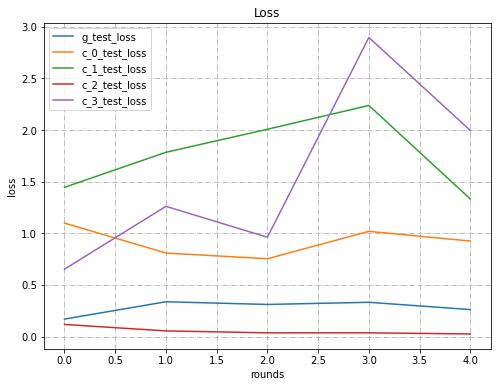

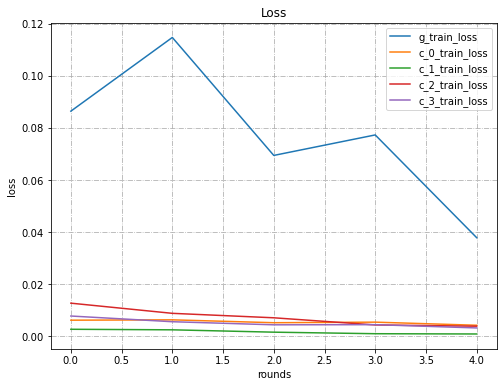

In [21]:
# Plot training history.
performance_log = utils.load_pickle(log_path)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'test_loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'rounds'
loss_plot_config['labels'] = ['g_test_loss'] + ['c_{}_test_loss'.format(client_idx) for client_idx in range(num_clients)]
loss_plot_config['attributes'] = ['g_test_loss'] + ['c_{}_test_loss'.format(client_idx) for client_idx in range(num_clients)]
utils.save_history_plot(performance_log, loss_plot_config)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'train_loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'rounds'
loss_plot_config['labels'] = ['g_train_loss'] + ['c_{}_train_loss'.format(client_idx) for client_idx in range(num_clients)]
loss_plot_config['attributes'] = ['g_train_loss'] + ['c_{}_train_loss'.format(client_idx) for client_idx in range(num_clients)]
utils.save_history_plot(performance_log, loss_plot_config)

1. "test_loader" is used to evaluate the performance of the global model on the global test set, which includes data from all clients and attack types. This allows the evaluation of the global model's ability to generalize to different attack types present in the test set.

2. "g_train_loss" represents the average training loss of the global model on the global training data (this one has not explained yet??),
while "c_{}_train_loss" represents the training loss of each client model on their local training data.

3. "g_test_loss" represents the test loss of the global model on the global test set, while "c_{}_test_loss "represents the test loss of each client model on their local test sets

In [105]:
glob_model

DNN(
  (fc_layers): ModuleList(
    (0): Linear(in_features=1525, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [106]:
glob_model.state_dict()

OrderedDict([('fc_layers.0.weight',
              tensor([[ 0.0152, -0.0997,  0.0283,  ..., -0.0110,  0.0021,  0.0060],
                      [ 0.2085, -0.0007,  0.0859,  ..., -0.0256, -0.0162,  0.0272],
                      [ 0.0749, -0.0188,  0.0357,  ..., -0.0267, -0.0582, -0.0268],
                      ...,
                      [-0.0149, -0.0507, -0.1011,  ...,  0.0129,  0.0331, -0.0096],
                      [ 0.0750, -0.0370,  0.0162,  ..., -0.0685, -0.1007, -0.0926],
                      [ 0.0191, -0.0547, -0.0201,  ..., -0.0109, -0.0260,  0.0073]],
                     device='cuda:0')),
             ('fc_layers.0.bias',
              tensor([-0.0571,  0.0166,  0.0571, -0.0241,  0.0653, -0.0315, -0.0304, -0.0077,
                      -0.0091,  0.0350,  0.0163,  0.0108,  0.0486, -0.0651, -0.0367, -0.0487,
                       0.0041, -0.0275, -0.0099, -0.0034, -0.0265, -0.0703, -0.0753, -0.0255,
                      -0.0286, -0.0104,  0.0388,  0.0256,  0.0586, -0.0118, 

### Evaluate the global model all attacks type among clients

In [22]:
# Define the evaluation function
criterion = nn.CrossEntropyLoss()

def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100.0 * correct / total

    return test_loss, accuracy, predictions, true_labels

In [23]:
silo0_sub = CustomDataset('client_data/nids/0/0_test_new.csv')
silo1_sub = CustomDataset('client_data/nids/1/1_test_new.csv')
silo2_sub = CustomDataset('client_data/nids/2/2_test_new.csv')
silo3_sub = CustomDataset('client_data/nids/3/3_test_new.csv')

In [24]:
len(silo0_sub)

35077

In [25]:
test_silo0_sub = DataLoader(silo0_sub, batch_size=batch_size, shuffle=True)
test_silo1_sub = DataLoader(silo1_sub, batch_size=batch_size, shuffle=True)
test_silo2_sub = DataLoader(silo2_sub, batch_size=batch_size, shuffle=True)
test_silo3_sub = DataLoader(silo3_sub, batch_size=batch_size, shuffle=True)

In [111]:
len(test_silo0_sub)

1097

In [26]:
# Evaluate the model
test_loss, test_accuracy, predictions, true_labels = evaluate(glob_model, test_silo0_sub, criterion, device)

# Print the training and evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(true_labels, predictions)
print('Classification Report:')
print(report)

Test Loss: 0.0378, Test Accuracy: 98.18%
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13566
           1       1.00      0.97      0.98     21511

    accuracy                           0.98     35077
   macro avg       0.98      0.99      0.98     35077
weighted avg       0.98      0.98      0.98     35077



In [27]:
# Evaluate the model
test_loss, test_accuracy, predictions, true_labels = evaluate(glob_model, test_silo1_sub, criterion, device)

# Print the training and evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(true_labels, predictions)
print('Classification Report:')
print(report)

Test Loss: 0.0496, Test Accuracy: 99.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13464
           1       1.00      0.99      0.99     18283

    accuracy                           0.99     31747
   macro avg       0.99      0.99      0.99     31747
weighted avg       0.99      0.99      0.99     31747



In [28]:
# Evaluate the model
test_loss, test_accuracy, predictions, true_labels = evaluate(glob_model, test_silo2_sub, criterion, device)

# Print the training and evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(true_labels, predictions)
print('Classification Report:')
print(report)

Test Loss: 1.0728, Test Accuracy: 84.20%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     13687
           1       1.00      0.69      0.81     13650

    accuracy                           0.84     27337
   macro avg       0.88      0.84      0.84     27337
weighted avg       0.88      0.84      0.84     27337



In [29]:
# Evaluate the model
test_loss, test_accuracy, predictions, true_labels = evaluate(glob_model, test_silo3_sub, criterion, device)

# Print the training and evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(true_labels, predictions)
print('Classification Report:')
print(report)

Test Loss: 1.1187, Test Accuracy: 83.89%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     13591
           1       1.00      0.68      0.81     13746

    accuracy                           0.84     27337
   macro avg       0.88      0.84      0.84     27337
weighted avg       0.88      0.84      0.83     27337



## Intepretation:
Eventhough we have pros lik data security from FL, buts still facing cons:
1. FL model can predict certain attacks among all client
2. FL model is affected by dominated training silo clients, making its performance worse

=> because the non-idd data, we need to solve this

### Test on adv samples

In [40]:
import pandas as pd

In [123]:
truerandom_20_test = CustomDataset('datasets/nids/adv/20_adv_truerandom_test.csv')
incremental_20_test = CustomDataset('datasets/nids/adv/20_adv_incremental_test.csv')
all_20_test = CustomDataset('datasets/nids/adv/adv_all_benign_attack_20.csv')

In [124]:
truerandom_20_test.labels = truerandom_20_test.labels + 1

In [125]:
incremental_20_test.labels = incremental_20_test.labels + 1
all_20_test.labels = all_20_test.labels + 1

In [126]:
truerandom_20_test_loader = DataLoader(truerandom_20_test, batch_size=batch_size, shuffle=True)
incremental_20_test_loader = DataLoader(incremental_20_test, batch_size=batch_size, shuffle=True)
all_20_test_loader = DataLoader(all_20_test, batch_size=batch_size, shuffle=True)

In [127]:
# Evaluate the model
test_loss, test_accuracy, predictions, true_labels = evaluate(glob_model, truerandom_20_test_loader, criterion, device)

# Print the training and evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(true_labels, predictions)
print('Classification Report:')
print(report)

Test Loss: 0.3442, Test Accuracy: 91.61%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.92      0.96      1800

    accuracy                           0.92      1800
   macro avg       0.50      0.46      0.48      1800
weighted avg       1.00      0.92      0.96      1800



/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
# Evaluate the model
test_loss, test_accuracy, predictions, true_labels = evaluate(glob_model, incremental_20_test_loader, criterion, device)

# Print the training and evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(true_labels, predictions)
print('Classification Report:')
print(report)

Test Loss: 0.4825, Test Accuracy: 88.90%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.89      0.94      1000

    accuracy                           0.89      1000
   macro avg       0.50      0.44      0.47      1000
weighted avg       1.00      0.89      0.94      1000



In [ ]:
# Evaluate the model
test_loss, test_accuracy, predictions, true_labels = evaluate(glob_model, all_20_test_loader, criterion, device)

# Print the training and evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(true_labels, predictions)
print('Classification Report:')
print(report)

### Add benign samples + attack samples for testing

In [30]:
new_truerandom_20_test = CustomDataset('datasets/nids/adv/adv_truerandom_benign_attack_20.csv')
new_incremental_20_test = CustomDataset('datasets/nids/adv/adv_incremental_benign_attack_20.csv')
new_all_20_test = CustomDataset('datasets/nids/adv/adv_all_benign_attack_20.csv')

In [31]:
new_all_20_test.data

,ip_header_byte_2,ip_header_byte_3,ip_header_byte_4,ip_header_byte_5,ip_header_byte_6,ip_header_byte_7,ip_header_byte_8,ip_header_byte_10,ip_header_byte_11,tcp_header_byte_4,...,tcp_segment_data_byte_1451,tcp_segment_data_byte_1452,tcp_segment_data_byte_1453,tcp_segment_data_byte_1454,tcp_segment_data_byte_1455,tcp_segment_data_byte_1456,tcp_segment_data_byte_1457,tcp_segment_data_byte_1458,tcp_segment_data_byte_1459,label_bin
0,0.0,0.156863,0.078431,0.329412,0.25098,0.0,0.494118,0.443137,0.564706,0.698039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.235294,0.011765,0.674510,0.25098,0.0,0.329412,0.674510,0.141176,0.407843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.274510,0.709804,0.050980,0.12549,0.0,0.254902,0.176471,0.725490,0.223529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.156863,0.109804,0.145098,0.25098,0.0,0.494118,0.411765,0.749020,0.698039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.156863,0.043137,0.019608,0.25098,0.0,0.501961,0.074510,0.470588,0.858824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.0,0.156863,0.098039,0.737255,0.25098,0.0,0.501961,0.015686,0.756863,0.858824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7996,0.0,0.156863,0.149020,0.141176,0.25098,0.0,0.501961,0.972549,0.345098,0.858824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7997,0.0,0.156863,0.105882,0.788235,0.25098,0.0,0.525490,0.384314,0.105882,0.062745,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7998,0.0,0.156863,0.415686,0.988235,0.25098,0.0,0.501961,0.701961,0.501961,0.858824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [32]:
new_truerandom_20_test_loader = DataLoader(new_truerandom_20_test, batch_size=batch_size, shuffle=True)
new_incremental_20_test_loader = DataLoader(new_incremental_20_test, batch_size=batch_size, shuffle=True)
new_all_20_test_loader = DataLoader(new_all_20_test, batch_size=batch_size, shuffle=True)

In [33]:
# Evaluate the model
test_loss, test_accuracy, predictions, true_labels = evaluate(glob_model, new_truerandom_20_test_loader, criterion, device)

# Print the training and evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(true_labels, predictions)
print('Classification Report:')
print(report)

Test Loss: 0.0327, Test Accuracy: 99.61%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1800
           1       1.00      0.99      1.00      1800

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



In [34]:
# Evaluate the model
test_loss, test_accuracy, predictions, true_labels = evaluate(glob_model, new_incremental_20_test_loader, criterion, device)

# Print the training and evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(true_labels, predictions)
print('Classification Report:')
print(report)

Test Loss: 0.0411, Test Accuracy: 99.55%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1000
           1       1.00      0.99      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [35]:
# Evaluate the model
test_loss, test_accuracy, predictions, true_labels = evaluate(glob_model, new_all_20_test_loader, criterion, device)

# Print the training and evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(true_labels, predictions)
print('Classification Report:')
print(report)

Test Loss: 0.5167, Test Accuracy: 80.28%
Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      4000
           1       1.00      0.61      0.75      4000

    accuracy                           0.80      8000
   macro avg       0.86      0.80      0.79      8000
weighted avg       0.86      0.80      0.79      8000

